## Flood Vulnerability Index (FVI) Assessment and Mapping

In [109]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
import fhv

# UPAZILA SHAPEFILE
# ------------------------------------------------- #
shape = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape.loc[shape['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape.loc[shape['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape['ADM3_PCODE'] = shape['ADM3_PCODE'].astype(int)
# with fiona.open('./data/adm_upazila.shp', "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]
# ------------------------------------------------- #

In [111]:
# Load data
data = pd.read_hdf('./data/data.hdf')
data_dist = pd.read_hdf('./data/data_dist.hdf')
data_table = pd.read_hdf('./data/data_table.hdf')
# Add a dot to the district variables
name_dot = data_table['Name'].copy()
name_dot[data_table['Scale'] == "District"] = name_dot[data_table['Scale'] == "District"] + '*'

# Label short names
data_table['Domain'] = data_table['Domain'].replace({'Demographic':'DEMO', 
                                                     'Health':'HEALTH', 
                                                     'Social':'SOCIAL',
                                                     'Adaptive Capacity':'ADAPT CAPACITY',
                                                     'Economic':'ECONOMIC',
                                                     'Built':'BUILT'})
data = data[data_table['Name']]
data_table

,Name,Sign,Type,Domain,Description,Normalization,Scale,Source
0,PAGEWEAK,pos,Person,DEMO,Percent of weak population (age below 5 or abo...,MinMax,Upazila,BBS (2011)
1,PFEMALE,pos,Person,DEMO,Percent of woman,MinMax,Upazila,BBS (2011)
2,PDISABL,pos,Person,DEMO,Percent of population with any sort of disability,MinMax,Upazila,BBS (2011)
3,PRURAL,pos,House,BUILT,Percent of households in rural areas,MinMax,Upazila,BBS (2011)
4,PWEAKBUILT,pos,House,BUILT,Percent of households with weak materials,MinMax,Upazila,BBS (2011)
5,PNOWATER,pos,House,BUILT,Percent of households without public water supply,MinMax,Upazila,BBS (2011)
6,PNOSANITARY,pos,House,BUILT,Percent of households without sanitary facilities,MinMax,Upazila,BBS (2011)
7,PNOELEC,pos,House,BUILT,Percent of households without electricity,MinMax,Upazila,BBS (2011)
8,PLITERACY,pos,Person,SOCIAL,Percent of population who cannot read and write,MinMax,Upazila,BBS (2011)
9,PETHNIC,pos,Person,SOCIAL,Percent of ethnic population,MinMax,Upazila,BBS (2011)


### Correlation Matrix

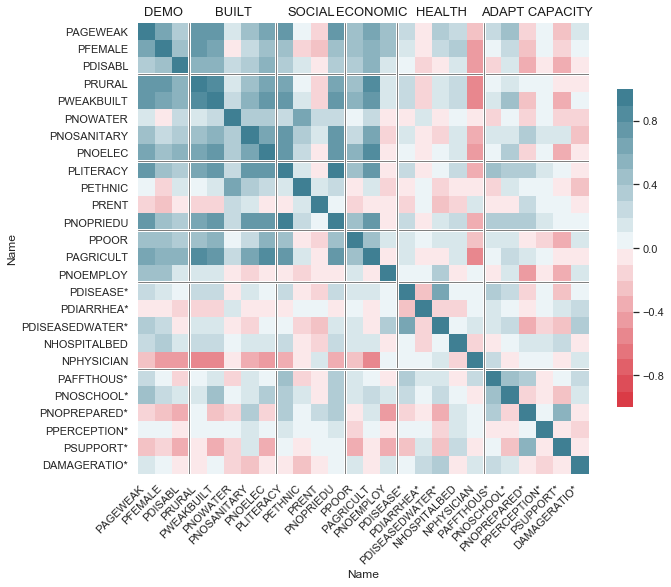

In [115]:
# Correlation Matrix
corrmat = data.corr()
corrmat_dist = data_dist.corr()
index = data_table[data_table['Scale'] == 'District'].index
# - Replace Upazila correaltions to District correlation for district-level variables
corrmat.iloc[index,:] = corrmat_dist.iloc[index,:]
corrmat.iloc[:,index] = corrmat_dist.iloc[:,index]
# - Replace name_dot
corrmat.columns = name_dot; corrmat.index = name_dot

# Plotting
sns.set(style="white", font_scale=1)
cmap=sns.diverging_palette(10, 220, n=20)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corrmat, ax=ax, vmin=-1, vmax=1, center=0,
                 cmap=cmap, square=True,
                 cbar_kws={'orientation': 'vertical', 'shrink':.5})

# Domains
# domain_name = ['DEMO','HEAL','SOCIO-ECON']
sources = data_table['Domain'].tolist()
for i, source in enumerate(sources):
    if i and source != sources[i - 1]:
        # Domain lines
        ax.axhline(i-0.05, c="w", lw=3)
        ax.axhline(i-0.05, c="grey", lw=1)
        ax.axvline(i-0.05, c="w", lw=3)
        ax.axvline(i-0.05, c="grey", lw=1)
    if source != sources[i - 1]:
        # Domain names
        lx = np.arange(len(corrmat))[np.isin(sources, source)]
        ax.annotate(source, [np.median(lx)+0.5, -0.4], 
                    xycoords='data', annotation_clip=False,
                    color='k', ha='center', fontfamily='sans-serif', fontsize=13)

ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.tight_layout()
plt.show()

# Save a figure
if False:
    fn_save = './figures/corrmat.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### Vulnerability Assessments
#### (1) Equal weights 

In [97]:
# Empty vulnerability dataframe
vuln = pd.DataFrame(index=data.index.astype('int'))

# Equal weights
nind = data.shape[1]
vuln['equal'] = np.dot(data.values, np.ones(nind)/nind)

#### (2) Random weights

In [98]:
# Sensitivity analysis with random weights
nt = 1000      # Must be a multiple of 100
thsd = 0.55
freq = np.zeros([data.shape[0],1])
for i in range(nt//100):
    rwgt = np.random.random([data.shape[1],100])
    rwgt = rwgt/rwgt.sum(axis=0)
    score = np.dot(data,rwgt)
    freq += (score > thsd).sum(1)[:,None]
vuln['random'] = freq/nt

In [99]:
# Merge all vulnerabilities
map_upazila = pd.merge(shape, vuln, left_on='ADM3_PCODE', right_on='ADM3_PCODE', how='outer')

### Initialize mapping parameters

In [100]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'jet', labloc='on',
                                                        boundaries=boundaries, extension='both')

### Mapping with equal weights 

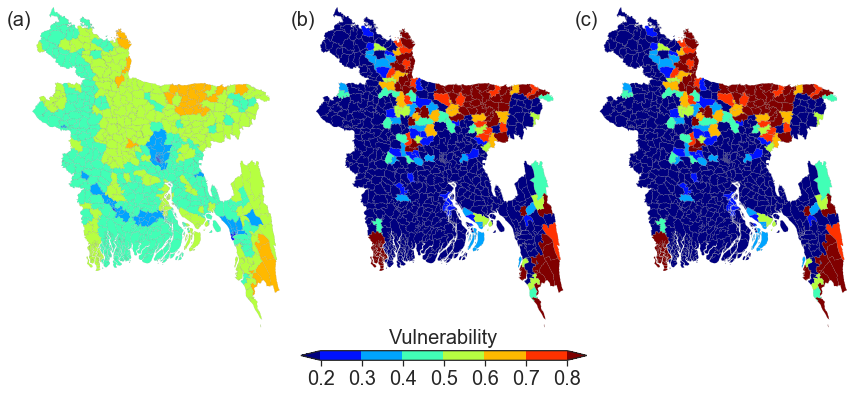

In [101]:
# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Vulnerability'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate(['equal','random','random']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_upazila.plot(ax=ax, column=el, 
            cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.1, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.05, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)    
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-1.2, -0.1, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=20)
cbar.set_label(figlabel, labelpad=-60, 
               fontname='arial', fontsize=20, 
               horizontalalignment='center')
plt.show()

In [5]:
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1)  # Flood depth (decuple)
# fcst = np.array(fcst >= 20).astype(np.int8).flatten()


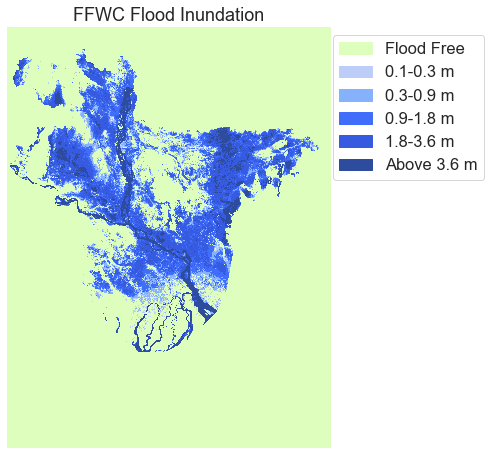

In [45]:
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from rasterio.plot import plotting_extent
import seaborn as sns
import fiona
from descartes import PolygonPatch
sns.set(font_scale=1.5, style="white")


# Define the colors
class_bin = np.array([0,1.01,3,9,18,36,100])
class_label = ['Flood Free','0.1-0.3 m','0.3-0.9 m','0.9-1.8 m','1.8-3.6 m','Above 3.6 m']
class_rgb = [[222,254,190],[188,205,247],[134,177,252],[65,109,251],[54,91,224],[45,76,157]]
class_rgb = list(np.array(class_rgb)/255)
cmap = ListedColormap(class_rgb)
cmap.name = class_name
# Define a normalization from values -> colors
norm = colors.BoundaryNorm(class_bin, len(class_bin))

# Plot raster
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7), facecolor='w')
im = ax.imshow(fcst,cmap=cmap,norm=norm)
# Title
ax.set_title("FFWC Flood Inundation")
# Legend
patches = [ mpatches.Patch(color=class_rgb[i],label=class_label[i]) for i in range(len(class_label)) ]
ax.legend(handles=patches,bbox_to_anchor=(1.5, 1),facecolor="white")
# Post-setting
plt.tight_layout()
ax.set_axis_off()
plt.show()

In [ ]:
# # Mapping
# sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# # Plotting
# figlabel = 'Vulnerability (Equal)'
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,5), facecolor='w')
# ax.set_axis_off()
# ax.set_aspect('equal')
# ax.axis(lims)
# map_upazila.plot(ax=ax, column='equal', linewidth=0.1, edgecolor='grey', 
#         cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)  
# plt.tight_layout()
# # Colorbar
# cax = inset_axes(ax, width="46%", height="3%",
#                  loc='lower left',
#                  bbox_to_anchor=(0, -0.1, 2.5, 1),
#                  bbox_transform=ax.transAxes,borderpad=0)
# cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
#                                  boundaries=boundaries,
#                                  extend='both',
#                                  extendfrac=0.08,
#                                  ticks = ticks,
#                                  spacing='uniform',
#                                  orientation='horizontal')
# cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
#                         fontname='arial', fontsize=15)
# cbar.set_label(figlabel, labelpad=-60, 
#                fontname='arial', fontsize=15, 
#                horizontalalignment='center')
# plt.show()